# Project 3 - SVM model

In [1]:
###############################################################
# Author: Jia Zheng  
# feature options : "SITF", "SURF", "ORB", "RGB", "HOG"
# kmeans method: mini-batch kmeans
# Model: rbf-kernel SVM        
###############################################################


import cv2
import numpy as np
from sklearn import svm
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.externals import joblib
from sklearn.model_selection import cross_validate
import os
import random
import time
import pandas as pd
import re
import matplotlib.pyplot as plt

## Step 0: specify directories

In [94]:
img_test_dir = "../data/test/image/"
img_train_dir = "../data/train/image/"

label_test_dir = "../data/test/label/"
label_train_dir = "../data/train/label/"

output_test_dir = "../output/test/"
output_train_dir = "../output/train/"
output_model_dir = "../output/model/"

## Step 1: set up controls for evaluation experiments 

In [95]:
run_cv = True # run cross-validation on the training set
run_feature_train = False # process features for training set
run_feature_test = False # process features for test set
run_model_test = True # run evaluation on an independent test set


# N_sample = 50000
N_cluster = 50
N_CV_fold = 5


# feature options : "SITF", "SURF", "ORB", "RGB", "HOG"
# feature dimension   128     64      32    64    54
# default: "HOG"
featureSelect = "HOG"
d = 54


## Step 2: import training images class labels.

In [46]:
% run "../lib/labelResponse.py"

In [47]:
# label_csv = pd.read_csv('../data/label_train.csv')
# train_label = labelResponse(img_train_dir, label_csv)
# filename = label_train_dir + "label.npy"
# np.save(filename, train_label)

train_label = np.load(label_train_dir + "label.npy")
print(train_label.shape)

(2400,)


In [48]:
# test_label = labelResponse(img_test_dir, label_csv)
# filename = label_test_dir + "label.npy"
# np.save(filename, test_label)

test_label = np.load(label_test_dir + "label.npy")
print(test_label.shape)

(600,)


## Step 3: Construct feature data

In [49]:
% run "../lib/ConstructFeatureData.py"

In [50]:
if run_feature_train:
    t0 = time.time()
    print("Extract features from train set ...")
    extractFeature(img_train_dir, output_train_dir, featureSelect, d) 
    print("Learn vocabulary of features ...")
    learnVocabulary(output_train_dir, featureSelect, N_cluster)  
    print("Construct data for train set ...")
    constructData(img_train_dir, output_train_dir, output_train_dir, featureSelect, N_cluster)
    constuct_train_data_time = round(time.time() - t0, 2)
    print("Time:", str(constuct_train_data_time), "s")

Extract features from train set ...
Extract (1119865, 32) ORB features from 2400 images
Learn vocabulary of features ...
Method: Mini-Batch Kmeans
Construct data for train set ...
The shape of construct data is (2400, 50)
Time: 271.52 s


In [51]:
if run_feature_test:
    t0 = time.time()
    print("Extract features from test set ...")
    extractFeature(img_test_dir, output_test_dir, featureSelect, d)
    print("Construct data for test set ...")
    constructData(img_test_dir, output_test_dir, output_train_dir, featureSelect, N_cluster)    
    constuct_test_data_time = round(time.time() - t0, 2)
    print("Time:", str(constuct_test_data_time), "s")

Extract features from test set ...
Extract (282406, 32) ORB features from 600 images
Construct data for test set ...
The shape of construct data is (600, 50)
Time: 39.44 s


## Step 4: Train a classification model with training images

In [96]:
% run "../lib/GridCV.py"
% run "../lib/trainModel.py" 

Now conduct cross validation ...


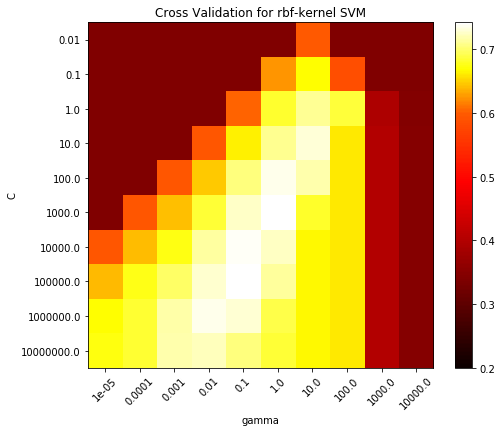

Select tuning parameter C = 1000.0
Select tuning parameter gamma = 1.0
Corresponding test score =  0.742083333333
Now retain model based on C-opt and gamma-opt ...
Classifier:
SVC(C=1000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1.0, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Time: 4441.94 s


In [97]:
t0 = time.time()
if run_cv: 
    parameters_opt = GridCV(featureSelect, N_CV_fold)
    C_opt = parameters_opt['C']
    gamma_opt = parameters_opt['gamma']
    print("Now retain model based on C-opt and gamma-opt ...")
else: 
    C_opt = 1
    gamma_opt = "auto"
    print("Now train model without cross validation ...")
    
trainClassifier(featureSelect, C_opt, gamma_opt)
model_train_time = round(time.time() - t0, 2)
print("Time:", str(model_train_time), "s")

## Step 5: Make prediction


In [98]:
% run "../lib/testModel.py"

In [99]:
if run_model_test:
    print("Now classify test set images ...")
    t0 = time.time()
    classify(featureSelect) 
    model_test_time = round(time.time() - t0, 2)  
    print("Time:", str(model_test_time), "s")

Now classify test set images ...
Total accuracy:  446 / 600 = 0.7433
Time: 0.12 s


## Summarize Running Time

In [174]:
print("Time for constructing training data =", str(constuct_train_data_time), "s")
print("Time for constructing testing data =", str(constuct_test_data_time), "s")
print("Time for training model =", str(model_train_time), "s")
print("Time for making prediction =", str(model_test_time), "s")

Time for constructing training data = 271.52 s
Time for constructing testing data = 39.44 s
Time for training model = 4441.94 s
Time for making prediction = 0.12 s


## Summary plot

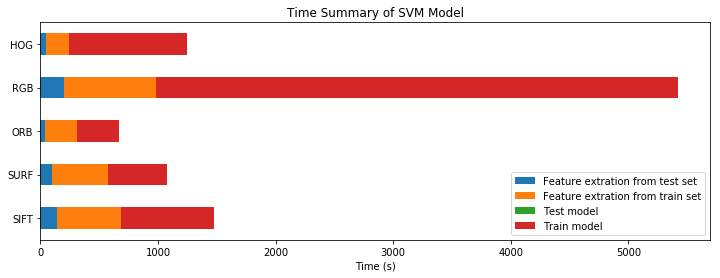

In [168]:
plt.figure()
time_table = {'Feature extration from train set': [548.72, 473.33, 271.52, 981.75*0.8, 244.39*0.8],
             'Feature extration from test set': [139.71, 100.18, 39.44, 981.75*0.2, 244.39*0.2],
             'Test model': [0.14, 0.11, 0.1, 0.12, 0.11],
             'Train model': [784.84, 499.19, 357.2, 4441.94, 998.89]}
timedf = pd.DataFrame(data=time_table)
ax = timedf.plot(kind='barh', stacked=True, figsize=(12,4))
ax.set_yticklabels(['SIFT','SURF','ORB','RGB','HOG'])
plt.xlabel("Time (s)")
plt.title("Time Summary of SVM Model")
plt.savefig("../figs/Time_summary.jpg") 
plt.show()

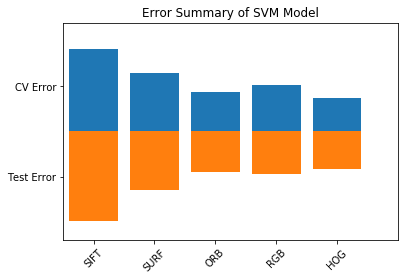

In [173]:
n = 5
X = np.arange(n)
Y1 = np.array([0.4546, 0.3208, 0.2167, 0.2579, 0.1867])
Y2 = np.array([0.4917, 0.325, 0.225, 0.2367, 0.205])

plt.figure(figsize=(8,6))

fig, ax1 = plt.subplots(1,1)

x1 = range(0,5)
squad1 = ['SIFT','SURF','ORB','RGB','HOG']

y1 = np.array([0.25, -0.25])
squad2 = ['CV Error','Test Error']

ax1.set_xticks(x1)
ax1.set_xticklabels(squad1, minor=False, rotation=45)

ax1.set_yticks(y1)
ax1.set_yticklabels(squad2, minor=False)

plt.bar(X, +Y1)
plt.bar(X, -Y2)

plt.xlim(-.5, n)
plt.ylim(-0.6, 0.6)

plt.ylabel("")
plt.title("Error Summary of SVM Model")
plt.savefig("../figs/Error_summary.jpg") 
plt.show()